In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from C4_theo_asymptotique__trapz import C4_court, C4_long
from DoubleRigidWallOverdampedBrownExp_Cython import RigidWallOverdampedLangevin3D
from Physic_function_problem import *
import cythonised_simu_part

from scipy.integrate import quad
from scipy.io import loadmat
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from numpy import trapz
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
from mpltools import annotation
from scipy.optimize import curve_fit

import csv


def cm2inch(value):
    return value / 2.54

from tqdm import tqdm


from matplotlib import rc
import seaborn as sns
custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.3,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif",
    "font.size":8,
    'axes.titlesize':10,
    'axes.labelsize':10,
}
# sns.set_context("notebook", rc={"lines.linewidth": 3})


sns.set_theme(context = "paper", style="ticks", rc=custom_params)

In [2]:
# mpl.rcParams.keys()

In [3]:
# Param fixé comme expériences
a = 1.519e-6 #1.12e-6/2
H = 40e-6
lD = 88.0e-9 #Répultion mur
kBT=1.38e-23*300
lB = 526e-9 #gravité
B = 5.0
eta=0.001

zz = np.linspace(-H+H*1e-3, H-H*1e-3, 1000)

dt = 1e-2
Nt = 10000000
Nt_sub = 1
tt = np.linspace(dt, dt*Nt, Nt)

In [4]:
simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, a=a, H=H, lD=lD, lB=lB, B=B, Nt_sub=Nt_sub)
simu.trajectory()

# Trajectory

In [5]:
Rs = np.zeros([Nt, 3])
Rs[:,0] = simu.x
Rs[:,1] = simu.y
Rs[:,2] = simu.z

In [6]:
def plot_3D(ax, N: int = 20, N_c: int = 500):
    """
    Plot the trajectory in 3D, using N chunks of N_c points with a gradient of color indicating the time.
    """
    plt.ioff()
    plt.ion()
    
    cmap = plt.get_cmap("jet")

    for i in range(N - 1):
        ax.plot(
            simu.x[i * N_c : i * N_c + N_c],
            simu.y[i * N_c : i * N_c + N_c],
            simu.z[i * N_c : i * N_c + N_c],
            color=plt.cm.jet(1 * i / N), alpha = 0.9
        )
        
    ax = plt.gca()
    ax.ticklabel_format(style="sci")

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])



# PDF$(z)$ et $D(z)$ $\|$ et $\perp$

In [7]:
# PDF(z)
position = Rs[:, 2]
bins=80

hist_z, bin_edges = np.histogram(position[position < 30e-6], bins=bins, density=False)
binsPositions = (bin_edges[:-1] + bin_edges[1:]) / 2 
pdf = hist_z / np.trapz(hist_z, binsPositions*1e6)

z_Peq = np.linspace(-H, -32e-6, 1000)

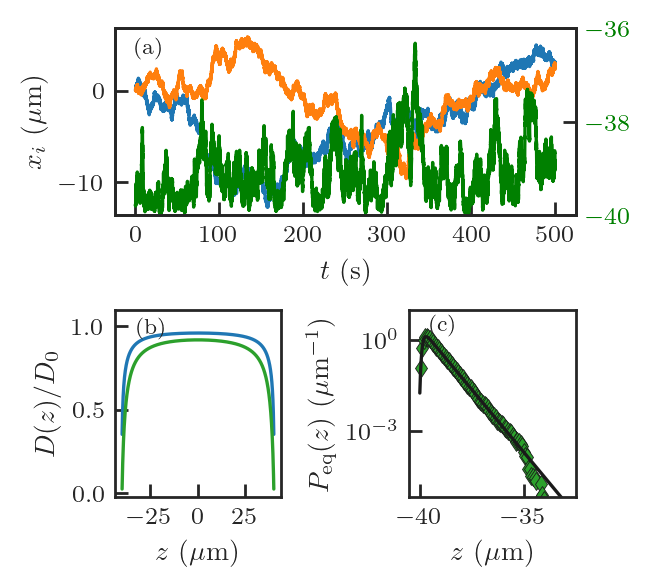

In [9]:
fig = plt.figure(figsize = (3.3, 5/1.68),  tight_layout=True)

ax1 = plt.subplot(211)
ax11=ax1.twinx()
ax11.plot(tt[:50000], simu.z[:50000]*1e6, "-", color="green")
ax11.set_ylabel("",color="green")
ax11.tick_params(axis='y', labelcolor="green")
ax11.set_ylim(-40, -36)
ax1.plot(tt[:50000], simu.x[:50000]*1e6, color="tab:blue")
ax1.plot(tt[:50000], simu.y[:50000]*1e6,  color="tab:orange")
ax1.set(
    xlabel = r"$t$ (s)",
    ylabel = r"$x_i$ ($\mu$m)",
)
ax1.text(0, 4, r"(a)", transform=ax1.transData)

ax2 = plt.subplot(223)
ax2.plot(zz*1e6, D_para(zz, a, eta, H)/D_0(zz, a, eta), "-", color="tab:blue", label=r"$D_\|(z)$")
ax2.plot(zz*1e6, D_perp(zz, a, eta, H)/D_0(zz, a, eta), "-", color="tab:green", label=r"$D_\perp(z)$")
ax2.set(
    xlabel = r"$z$ ($\mu$m)",
    ylabel = r"$D(z)/D_0$",
)
ax2.set_ylim(None, 1.1)
ax2.text(-32, 0.95, r"(b)", transform=ax2.transData)


ax3 = plt.subplot(224)
ax3.semilogy(binsPositions*1e6, pdf, "d", color="tab:green", label=r"$\mathrm{Simulation}$")
ax3.plot(z_Peq*1e6, P_eq(z_Peq, B, lD, lB, H)/np.trapz(P_eq(z_Peq, B, lD, lB, H), z_Peq*1e6), "k-", label=r"$\mathrm{Theory}$",)
ax3.set(
    xlabel = r"$z$ ($\mu$m)",
    ylabel = r"$P_\mathrm{eq}(z)$ ($\mu$m$^{-1}$)",
)
ax3.set_xlim(-40.5, -32.5)
ax3.set_ylim(7e-6, 10)
ax3.text(-39.5, 2, r"(c)", transform=ax3.transData)

fig.tight_layout()

# plt.savefig("Figures/traj_Dz_PDFz.pdf")

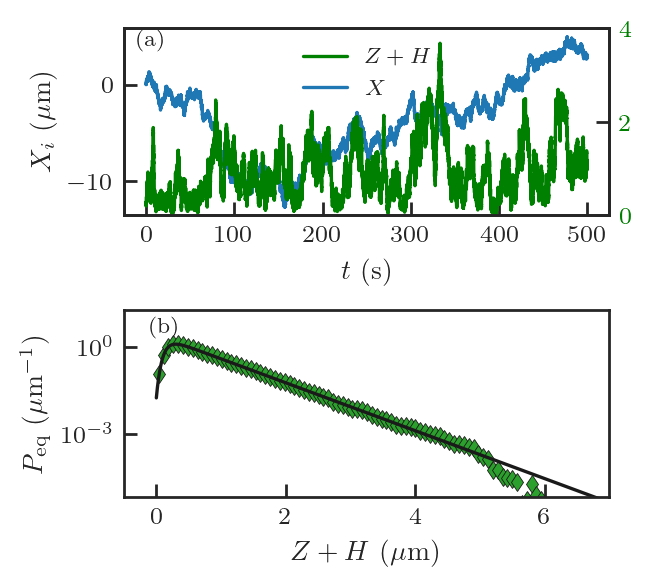

In [10]:
fig = plt.figure(figsize = (3.3, 5/1.68),  tight_layout=True)

ax1 = plt.subplot(211)
ax11=ax1.twinx()
l1 = ax11.plot(tt[:50000], simu.z[:50000]*1e6 +40, "-", color="green", label=r"$Z+H$")
ax11.set_ylabel("",color="green")
ax11.tick_params(axis='y', labelcolor="green")
ax11.set_ylim(0, 4)
l2 = ax1.plot(tt[:50000], simu.x[:50000]*1e6, color="tab:blue", label=r"$X$")
# ax1.plot(tt[:50000], simu.y[:50000]*1e6,  color="tab:orange")

lns = l1 + l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper center', frameon=False, fontsize=8)

ax1.set(
    xlabel = r"$t$ (s)",
    ylabel = r"$X_i$ ($\mu$m)",
)
ax1.text(-10, 4, r"(a)", transform=ax1.transData)
#ax1.plot("-", color="green", label=r"$Z$")

#ax1.legend(loc='upper center', frameon=False, fontsize=8)

ax3 = plt.subplot(212)
ax3.semilogy(binsPositions*1e6 + H*1e6, pdf, "d", color="tab:green", label=r"$\mathrm{Simulation}$")
ax3.plot(z_Peq*1e6 + H*1e6, P_eq(z_Peq, B, lD, lB, H)/np.trapz(P_eq(z_Peq, B, lD, lB, H), z_Peq*1e6), "k-", label=r"$\mathrm{Theory}$",)
ax3.set(
    xlabel = r"$Z+H$ ($\mu$m)",
    ylabel = r"$P_\mathrm{eq}$ ($\mu$m$^{-1}$)",
)
ax3.set_xlim(-0.5, 7)
ax3.set_ylim(7e-6, 20)
ax3.text(-0.1,3, r"(b)", transform=ax3.transData)

fig.tight_layout()
# plt.savefig("Figures/traj_PDFz.pdf")

# MSD

In [11]:
tau_MSDx, msd_x = simu.MSD("x")

100%|████████████████████████████████████████| 63/63 [00:01<00:00, 45.09it/s]


In [12]:
tau_MSDz, msd_z = simu.MSD("z")

100%|████████████████████████████████████████| 63/63 [00:01<00:00, 42.77it/s]


In [13]:
mean_Dx = np.trapz(P_eq(zz, B, lD, lB, H)/np.trapz(P_eq(zz, B, lD, lB, H), zz)*D_para(zz, a, eta, H), zz)
mean_Dz = np.trapz(P_eq(zz, B, lD, lB, H)/np.trapz(P_eq(zz, B, lD, lB, H), zz)*D_perp(zz, a, eta, H), zz)

In [14]:
mean_Dz

3.84014987009805e-14

In [15]:
N_tau = 1

# tau_theo = np.linspace(5e-3, 5e6, 1000)
# PDF(dX)
dX = simu.x[N_tau:] - simu.x[:-N_tau]
std_num_dX = np.std(dX)
hist, bin_edges = np.histogram(dX, bins=50, density=False)
binsPositions_dX = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_dX = hist / np.trapz(hist, binsPositions_dX*1e6)


# PDF(dZ) court
dZ = simu.z[N_tau:] - simu.z[:-N_tau]
std_num_dZ = np.std(dZ)
hist, bin_edges = np.histogram(dZ, bins=50, density=False)
binsPositions_dZ = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_dZ = hist / np.trapz(hist, binsPositions_dZ*1e6)

# PDF(dZ) long
N_tau_long = 10000
dZ_long = simu.z[N_tau_long:] - simu.z[:-N_tau_long]
std_num_dZ_long = np.std(dZ_long)
hist, bin_edges = np.histogram(dZ_long, bins=50, density=False)
binsPositions_dZ_long = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_dZ_long = hist / np.trapz(hist, binsPositions_dZ_long*1e6)

dXX = np.linspace(-0.5, +0.5, 1000)
PDF_theory_x = P_Di_short_time(dXX*1e-6, dt*N_tau, D_para, a, eta, B, lD, lB, H)

dZZ = np.linspace(-0.8, +0.8, 1000)
PDF_theory_z = P_Di_short_time(dZZ*1e-6, dt*N_tau, D_perp, a, eta, B, lD, lB, H)

dZZ_long = np.linspace(-2*(H), 2*(H), 10000)
PDF_theory_z_long = Pdeltaz_long(dZZ_long, B, lD, lB, H)

plateau = np.trapz(dZZ_long**2 * PDF_theory_z_long, dZZ_long)

plateauC4z = np.trapz(dZZ_long**4 * PDF_theory_z_long, dZZ_long)

In [16]:
N_tau*dt, N_tau_long*dt

(0.01, 100.0)

In [17]:
plateauC4z = np.trapz(dZZ_long**4 * PDF_theory_z_long , dZZ_long) - 3 * np.trapz(dZZ_long**2 * PDF_theory_z_long , dZZ_long) ** 2 

# Cumulant 4

In [18]:
data_simu = loadmat("C4_Datas/dataC4Ssimu_papier.mat", squeeze_me=True)


c4_simu = data_simu["C4"]
time_c4_simu = data_simu["t"]

In [19]:
D4_long_theo = 1.2691e-27 #1.5074e-27
C4_long_theo = 1.0350e-26 #1.4039e-26
A4_theo_x = C4_court(D=D_para, Peq=P_eq, kBT=kBT, B=B, lD=lD, lB=lB, H=H, a=a, eta=eta, dx=1e-8)
A4_theo_z = C4_court(D=D_perp, Peq=P_eq, kBT=kBT, B=B, lD=lD, lB=lB, H=H, a=a, eta=eta, dx=1e-8)

t_short = np.linspace(1e-4, 50, 1000)
t_long = np.linspace(20, 1e5, 1000)

# Convergence

In [20]:
n_court = 0
n_mid = 17
n_long = -11

## -> plot C4

In [21]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# X datas
Datas_parquet = "C4_Datas/convergence_7_50_sigma__lD_8p800000e-08_lB_5p260000e-07_B_5p000000e+00_H_4p000000e-05_a_1p519000e-06_dt_1p000000e-02_Nt_1000000_Ntsub_1_/"

dt = float(Datas_parquet.replace("p", ".").split("_")[-6])

#Récupération des datas
pd.read_parquet(Datas_parquet+'/1', engine='pyarrow')
files=glob.glob(Datas_parquet+"/*")

# Les mettres dans l'ordre
Ntime = []
for i in files:
    Ntime.append(int(i.split("/")[-1]))

I=np.argsort(Ntime)
files = [files[i] for i in I]

Ntime = np.sort(Ntime)

len(files)

47

In [23]:
# Z datas
Datas_parquet_z = "C4_Datas/z_convergence_7_50_sigma__lD_8p800000e-08_lB_5p260000e-07_B_5p000000e+00_H_4p000000e-05_a_1p519000e-06_dt_1p000000e-02_Nt_1000000_Ntsub_1_/"
dt = float(Datas_parquet_z.replace("p", ".").split("_")[-6])

#Récupération des datas
pd.read_parquet(Datas_parquet_z+'/1', engine='pyarrow')
files_z=glob.glob(Datas_parquet_z+"/*")

# Les mettres dans l'ordre
Ntime_z = []
for i in files_z:
    Ntime_z.append(int(i.split("/")[-1]))

I=np.argsort(Ntime_z)
files_z = [files_z[i] for i in I]

Ntime_z = np.sort(Ntime_z)

len(files_z)


47

In [24]:
dt = float(Datas_parquet.replace("p", ".").split("_")[-6])

tau_x = Ntime*dt
tau_z= Ntime_z*dt


In [25]:
# Calcul C4 avec MÉTHODE_1 <PDF> -> C4

C4_x = []
for i in tqdm(files):
    datas = pd.read_parquet(i)
    dx = np.array(datas.columns).astype(float)
    
    #Moyenne des PDFs
    datas = datas.to_numpy()
    datas = np.sum(datas, axis=0)
    datas = datas / np.trapz(datas, dx)
    
    #Calcul du C4_x
    C4_x.append(np.trapz(dx**4 *datas, dx) - 3* (np.trapz(dx**2 * datas, dx))**2)



100%|████████████████████████████████████████| 47/47 [01:18<00:00,  1.68s/it]


In [26]:
# Calcul C4_z avec MÉTHODE_1 <PDF> -> C4

C4_z = []
for i in tqdm(files_z):
    datas_z = pd.read_parquet(i)
    dz = np.array(datas_z.columns).astype(float)
    
    #Moyenne des PDFs
    datas_z = datas_z.to_numpy()
    datas_z = np.sum(datas_z, axis=0)
    datas_z = datas_z / np.trapz(datas_z, dz)
    
    #Calcul du C4_x
    C4_z.append(np.trapz(dz**4 *datas_z, dz) - 3* (np.trapz(dz**2 * datas_z, dz))**2)



100%|████████████████████████████████████████| 47/47 [01:16<00:00,  1.62s/it]


In [27]:
# Calcul C4 avec MÉTHODE_2 PDF -> C4 -> <C4>

# C4_xM2 = []

# for i in tqdm(files):
#     datas = pd.read_parquet(i)
#     dx = np.array(datas.columns).astype(float)
#     tampon = []
#     #PDFs
#     datas = datas.to_numpy()
#     for j in (range(len(datas[:,0]))):
#         if sum(datas[j, :]) != 0:
#             #Calcul des C4_x
#             PDF = datas[j,:] / np.trapz(datas[j,:], dx)
#             tampon.append( np.trapz(dx**4 *PDF, dx) - 3* (np.trapz(dx**2 * PDF, dx))**2 )
    
#     # Moyenne des C4s
#     C4_xM2.append(np.mean(tampon))

# del tampon
# del PDF


# from scipy.io import savemat

# C4_from_methode2 = {}
# C4_from_methode2["time (s)"] = tau_x
# C4_from_methode2["C4 (m^4)"] = C4_xM2

# savemat("C4_Datas/C4_ComputeWithMethode2_MeanOfC4.mat", C4_from_methode2)

In [28]:
M2_c4 = loadmat("C4_Datas/C4_ComputeWithMethode2_MeanOfC4.mat", squeeze_me=True)
np.shape(M2_c4["C4 (m^4)"])

(47,)

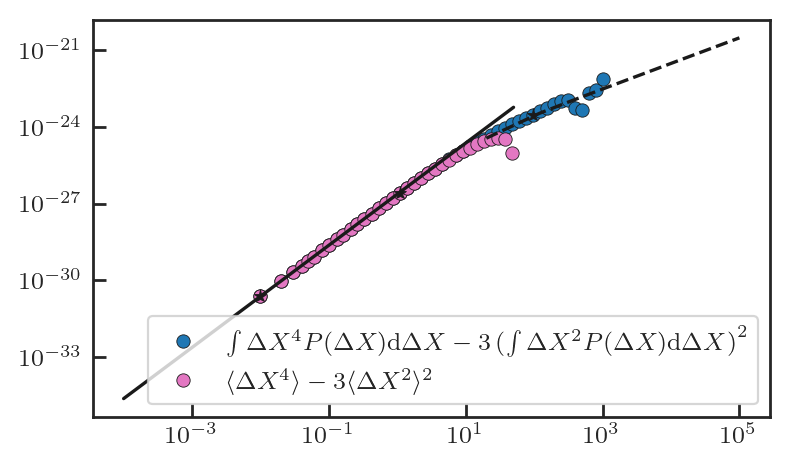

In [29]:
fig = plt.figure(figsize = (4, 4/1.68),  tight_layout=True)

ax1 = plt.subplot(111)

ax1.loglog(tau_x, C4_x, "o", color="tab:blue", label=r"$\int \Delta X^4 P(\Delta X) \mathrm{d}\Delta X - 3 \left( \int \Delta X^2 P(\Delta X) \mathrm{d}\Delta X \right)^2 $")
ax1.loglog(M2_c4["time (s)"], M2_c4["C4 (m^4)"], "o", color="tab:pink", label=r"$\langle \Delta X^4 \rangle - 3 \langle \Delta X^2 \rangle^2$")
ax1.plot(tau_x[n_court], C4_x[n_court], "k*")
ax1.plot(tau_x[n_mid], C4_x[n_mid], "k*")
ax1.plot(tau_x[n_long], C4_x[n_long], "k*")
ax1.plot(t_short, A4_theo_x*t_short**2, "k-" )
ax1.plot(t_long, 24*D4_long_theo*t_long-24*C4_long_theo, "k--" )

# ax1.loglog(tau_z, C4_z, "d", color="tab:green", label="z")
# ax1.plot(t_short, A4_theo_z*t_short**2, "k-" )
# ax1.plot(t_long, plateauC4z*np.ones(len(t_long)), "k--" )

plt.legend()

\begin{equation}
\langle X^4 \rangle_\mathrm{c} = \langle X^4 \rangle - 3 \langle X^2 \rangle^2
\end{equation}

donc 
\begin{equation}
\mathrm{Kurtosis} = \frac{\langle X^4 \rangle}{\langle X^2 \rangle^2} - 3
\end{equation}

avec $\langle X^2 \rangle^2 = (2 \langle D_\|\rangle \tau)^2$

quand $\tau \rightarrow 0$, $\langle X^4 \rangle_\mathrm{c} \rightarrow A_4 \tau^2$ 

donc $\frac{\langle X^4 \rangle_\mathrm{c}}{\langle X^2 \rangle^2} \rightarrow \frac{A_4}{4 \langle D_\| \rangle^2 } $


In [30]:
# Calcul C4 normalisé

C4_x_normalised = []
for i in tqdm(files):
    datas = pd.read_parquet(i)
    dx = np.array(datas.columns).astype(float)
    
    #Moyenne des PDFs
    datas = datas.to_numpy()
    datas = np.sum(datas, axis=0)
    datas = datas / np.trapz(datas, dx)
    
    #Calcul du C4_x_
    C4_x_normalised.append(np.trapz(dx**4 *datas, dx)/(np.trapz(dx**2 * datas, dx)**2) - 3)



100%|████████████████████████████████████████| 47/47 [01:21<00:00,  1.74s/it]


In [31]:
# # Calcul C4_z normalisé

# C4_z_normalised = []
# for i in tqdm(files_z):
#     datas_z = pd.read_parquet(i)
#     dz = np.array(datas_z.columns).astype(float)
    
#     #Moyenne des PDFs
#     datas_z = datas_z.to_numpy()
#     datas_z = np.sum(datas_z, axis=0)
#     datas_z = datas_z / np.trapz(datas_z, dz)
    
#     #Calcul du C4_x_
#     C4_z_normalised.append(np.trapz(dz**4 *datas_z, dz)/(np.trapz(dz**2 * datas_z, dz)**2) - 3)



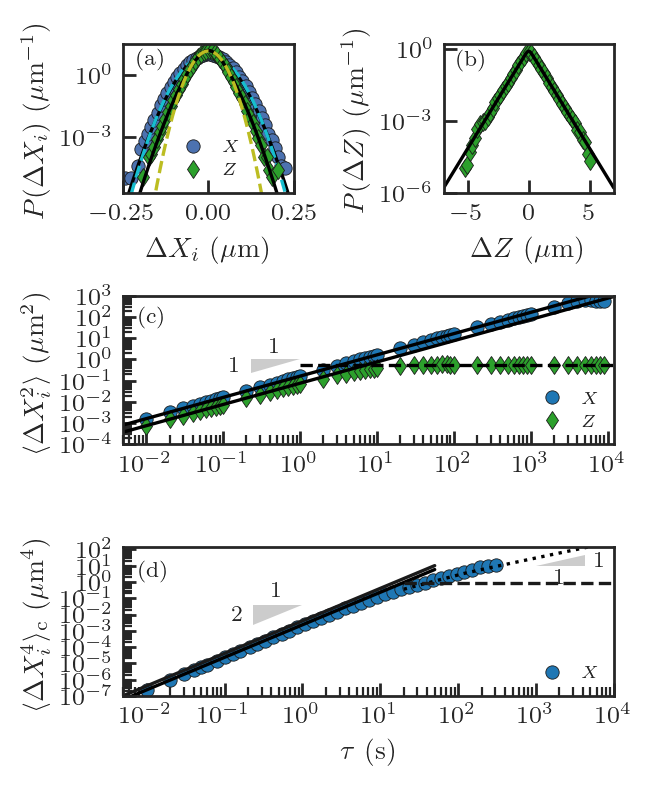

In [32]:
tau_theo = np.logspace(-4, 5, 100)

fig = plt.figure(figsize = (3.3, 6.5/1.68),  tight_layout=True)

ax1 = plt.subplot(321)
ax1.semilogy(binsPositions_dX*1e6, pdf_dX/np.trapz(pdf_dX,binsPositions_dX*1e6), "o", label=r"$X$")
ax1.plot(dXX, PDF_theory_x/np.trapz(PDF_theory_x,dXX), "-", color="black",)# label=r"Theory")
ax1.plot(dXX, gauss(dXX*1e-6, 0, np.sqrt(2*mean_Dx*dt*N_tau)) / np.trapz(gauss(dXX*1e-6, 0, np.sqrt(2*mean_Dx*dt*N_tau)), dXX), "--", color="tab:cyan",)# label=r"Gaussian")


ax1.semilogy(binsPositions_dZ*1e6, pdf_dZ/np.trapz(pdf_dZ,binsPositions_dZ*1e6), "d", color="tab:green", label="$Z$")
ax1.plot(dZZ, PDF_theory_z/np.trapz(PDF_theory_z,dZZ), "-", color="black",)# label="Theory")
ax1.plot(dZZ, gauss(dZZ*1e-6, 0, np.sqrt(2*mean_Dz*dt*N_tau)) / np.trapz(gauss(dZZ*1e-6, 0, np.sqrt(2*mean_Dz*dt*N_tau)), dZZ), "--", color="tab:olive",)
ax1.set_xlim(-0.25, 0.25)
ax1.set_ylim(2e-6, 30)
ax1.set(
    xlabel = r"$\Delta X_i$ ($\mu$m)",
    ylabel = r"$P(\Delta X_i)$  ($\mu$m$^{-1}$)",
)
ax1.text(-0.21, 3, r"(a)", transform=ax1.transData)
ax1.legend(loc='lower center', frameon=False, fontsize=6)


ax2 = plt.subplot(322)

ax2.semilogy(binsPositions_dZ_long*1e6, pdf_dZ_long/np.trapz(pdf_dZ_long,binsPositions_dZ_long*1e6), "d", color="tab:green")
ax2.plot(dZZ_long*1e6, PDF_theory_z_long/np.trapz(PDF_theory_z_long,dZZ_long*1e6), "-", color="black",)
ax2.set_xlim(-7, 7)
ax2.set_ylim(1e-6, 1.5)
ax2.set(
    xlabel = r"$\Delta Z$ ($\mu$m)",
    ylabel = r"$P(\Delta Z)$  ($\mu$m$^{-1}$)",
)
ax2.text(-5.9, 2e-1, r"(b)", transform=ax2.transData)



ax4 = plt.subplot(312)
ax4.loglog(tau_MSDx[:-9], msd_x[:-9]*1e12, "o", color="tab:blue", label=r"$X$")
ax4.loglog(tau_MSDz[:-9], msd_z[:-9]*1e12, "d", color="tab:green", label=r"$Z$")
ax4.plot(tau_theo, 2*tau_theo*mean_Dx*1e12, "-", color="black",)# label=r"$2 \langle D_{\|}(z) \rangle_0 \tau$")
ax4.plot(tau_theo, 2*tau_theo*mean_Dz*1e12, "-", color="black",)# label=r"$2 \langle D_{\perp}(z) \rangle_0 \tau$")
ax4.plot(np.linspace(1, 5e6, 1000), plateau*np.ones(1000)*1e12, "--",color="black")
ax4.set_xlim(5e-3, 1.2e4)
ax4.set_ylim(1e-4, 1e3)
ax4.set(
    # xlabel = r"$\tau$ (s)",
    ylabel = r"$\langle \Delta X_i^2 \rangle$ $(\mathrm{\mu  m}^2)$",
)
annotation.slope_marker((1, 1e-12*1e12), (1, 1), ax=ax4, invert=True)
ax4.text(8e-3, 5e-10*1e11, r"(c)", transform=ax4.transData)
ax4.legend(loc='lower right', frameon=False, fontsize=6)

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax4.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax4.yaxis.set_minor_locator(locmin)
ax4.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax4.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax4.xaxis.set_minor_locator(locmin)
ax4.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax5 = plt.subplot(313)

ax5.loglog(tau_x[:-5], np.array(C4_x[:-5])*1e24, "o", color="tab:blue", label="$X$")
# ax5.loglog(tau_z, np.array(C4_z)*1e24, "d", color="tab:green", label="$Z$")
ax5.plot(t_short, A4_theo_x*t_short**2*1e24, "-", color="black")
ax5.plot(t_long, (24*D4_long_theo*t_long-24*C4_long_theo) *1e24, ":", color="black", )
ax5.plot(t_short, A4_theo_z*t_short**2 *1e24 , "k-") #
ax5.plot(t_long, plateauC4z*np.ones(len(t_long))*1e24, "k--" )
ax5.set_ylim(1e-7, 1.4e2)
ax5.set_xlim(5e-3, 1e4)
ax5.set(
    xlabel = r"$\tau$ (s)",
    ylabel = r"$\langle \Delta X_i^4 \rangle_\mathrm{c}$ $(\mathrm{\mu m}^4)$",
)
ax5.legend(loc='lower right', frameon=False, fontsize=6)
annotation.slope_marker((1, 4e-26*1e24), (2, 1), ax=ax5, invert=True)
annotation.slope_marker((1000, 1e-23*1e24), (1 ,1), ax=ax5)
ax5.text(8e-3, 2e-23*1e23, r"(d)", transform=ax5.transData)

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax5.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax5.yaxis.set_minor_locator(locmin)
ax5.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax5.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax5.xaxis.set_minor_locator(locmin)
ax5.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


fig.tight_layout()

# plt.savefig("Figures/PDF_MSD_C4.pdf")

## -> etude convergence

In [33]:
filess = [files[n_court], files[n_mid], files[n_long]]

datas = {}
for i in filess:
    name = i.split("/")[-1]
    datas[name] = pd.read_parquet(i)

i = [str(Ntime[n_court]), str(Ntime[n_mid]), str(Ntime[n_long])]

data_1 = datas[i[0]].to_numpy()
dx_1 = np.array(datas[i[0]].columns).astype(float)

data_0 = datas[i[1]].to_numpy()
dx_0 = np.array(datas[i[1]].columns).astype(float)

data_2 = datas[i[2]].to_numpy()
dx_2 = np.array(datas[i[2]].columns).astype(float)


In [34]:
Convergence_court = A4_theo_x*tau_x[n_court]**2
Convergence_mid = 24*D4_long_theo*tau_x[n_mid]-24*C4_long_theo #C4_x[n_mid]
Convergence_long = 24*D4_long_theo*tau_x[n_long]-24*C4_long_theo

In [35]:
dts = [Ntime[n_court]*dt, Ntime[n_mid]*dt, Ntime[n_long]*dt]
dts

[0.01, 1.09, 95.4]

# 100 PDF($\Delta x$) de 1 trajectoires

In [36]:
# dxLONG = np.linspace(-60e-6, 60e-6, 100)
# dxMID = np.linspace(-20e-6, 20e-6, 100)
# dxCOURT = np.linspace(-0.4e-6, 0.4e-6, 1000)

# # 100 PDF de 1 trajectoires
# fig = plt.figure(figsize = (3.3, 9/1.68),  tight_layout=True)

# ax1 = plt.subplot(311)
# for i in range(1000):
#     ax1.semilogy(dx_1*1e6, data_1[i,:]/np.trapz(data_1[i,:], dx_1*1e6), "o")

# ax1.plot(dxCOURT*1e6, gauss(dxCOURT, 0, np.sqrt(2*mean_Dx*Ntime[n_court]*dt)) / np.trapz(gauss(dxCOURT, 0, np.sqrt(2*mean_Dx*Ntime[n_court]*dt)), dxCOURT*1e6), 
#          "--", color="tab:olive", linewidth=2,)
# ax1.plot(dx_1*1e6, np.sum(data_1[:,:], axis=0) / np.trapz(np.sum(data_1[:,:], axis=0), dx_1*1e6), "k*" )

# ax1.set_title(r"$\tau_1 = $ "+ str(Ntime[n_court]*dt) + " s")
# ax1.set_xlim(-0.3, 0.3)
# ax1.set_ylim(1e-5, 2e1)
# ax1.set(
#     # xlabel = r"$\Delta x$ ($\mu$m)",
#     ylabel = r"$P(\Delta x)$ ($\mu$m$^{-1}$)",
# )
# ax1.text(-0.28, 6, r"(a)", transform=ax1.transData)


# ax0 = plt.subplot(312)
# for i in range(1000):
#     ax0.semilogy(dx_0*1e6, data_0[i,:]/np.trapz(data_0[i,:], dx_0*1e6), "o")
# ax0.plot(dxMID*1e6, gauss(dxMID, 0, np.sqrt(2*mean_Dx*Ntime[n_mid]*dt)) / np.trapz(gauss(dxMID, 0, np.sqrt(2*mean_Dx*Ntime[n_mid]*dt)), dxMID*1e6),
#         "--", color="tab:olive",linewidth=2,)
# ax0.plot(dx_0*1e6, np.sum(data_0[:,:], axis=0) / np.trapz(np.sum(data_0[:,:], axis=0), dx_0*1e6), "k*" )

# ax0.set_xlim(-12, 12)
# ax0.set_ylim(1e-7, 5e-1)
# ax0.set_title(r"$\tau_2 = $ "+ str(Ntime[n_mid]*dt) + " s")
# ax0.set(
#     # xlabel = r"$\Delta x$ ($\mu$m)",
#     ylabel = r"$P(\Delta x)$ ($\mu$m$^{-1}$)",
# )
# ax0.text(-11.2, 1e-1, r"(b)", transform=ax0.transData)   


# ax2 = plt.subplot(313)
# for i in range(1000):
#     ax2.semilogy(dx_2*1e6, data_2[i,:]/np.trapz(data_2[i,:], dx_2*1e6), "o")
# ax2.plot(dxLONG*1e6, gauss(dxLONG, 0, np.sqrt(2*mean_Dx*Ntime[n_long]*dt)) / np.trapz(gauss(dxLONG, 0, np.sqrt(2*mean_Dx*Ntime[n_long]*dt)), dxLONG*1e6), 
#          "--", color="tab:olive",linewidth=2,)
# ax2.plot(dx_2*1e6, np.sum(data_2[:,:], axis=0) / np.trapz(np.sum(data_2[:,:], axis=0), dx_2*1e6), "k*" )

# ax2.set_xlim(-45, 45)
# ax2.set_ylim(1e-7, 1.5e-1)
# ax2.set_title(r"$\tau_3 = $ "+ str(Ntime[n_long]*dt) + " s")
# ax2.set(
#     xlabel = r"$\Delta x$ ($\mu$m)",
#     ylabel = r"$P(\Delta x)$ ($\mu$m$^{-1}$)",
# )
# ax2.text(-42, 4e-2, r"(c)", transform=ax2.transData)  

# # plt.savefig("Figures/PDF_X_3times.pdf")

In [37]:
data_1 = data_1[np.sum(data_1, axis= 1) != 0]
data_0 = data_0[np.sum(data_0, axis= 1) != 0]
data_2 = data_2[np.sum(data_2, axis= 1) != 0]

In [38]:
dxLONG = np.linspace(-60e-6, 60e-6, 100)
dxMID = np.linspace(-15e-6, 15e-6, 100)
dxCOURT = np.linspace(-0.4e-6, 0.4e-6, 1000)

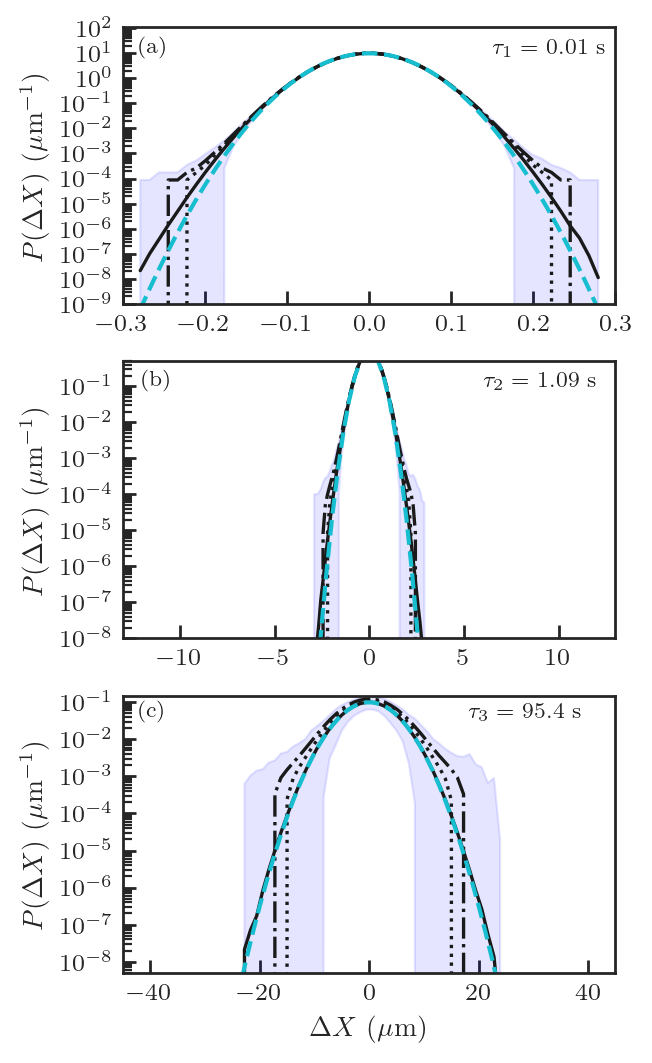

In [39]:


# toutes les PDF de 1 trajectoires
fig = plt.figure(figsize = (3.3, 9/1.68),  tight_layout=True)

ax1 = plt.subplot(311)
Min = np.min(data_1, axis=0)
Max = np.max(data_1, axis=0)
Mean = np.mean(data_1, axis=0)
Z = np.trapz(Mean, dx_1*1e6)
# Std  = np.std(data_1, axis=0)
# quantil25 = np.quantile(a=data_1, q=0.25, axis=0)
quantil1 = np.quantile(a=data_1, q=0.9, axis=0)
quantil2 = np.quantile(a=data_1, q=0.99, axis=0)
ax1.plot(dx_1*1e6, quantil1 / Z, "k:")
ax1.plot(dx_1*1e6, quantil2 / Z, "k-.")
ax1.semilogy(dx_1*1e6, Mean/ Z,"k-")
# ax1.plot(dx_1*1e6, quantil25 / Z, "k:")
ax1.fill_between(dx_1*1e6, Min / Z, Max / Z, color='blue', alpha=0.1)
ax1.semilogy(dxCOURT*1e6, gauss(dxCOURT, 0, np.sqrt(2*mean_Dx*Ntime[n_court]*dt)) / np.trapz(gauss(dxCOURT, 0, np.sqrt(2*mean_Dx*Ntime[n_court]*dt)), dxCOURT*1e6) , 
         "--", color="tab:cyan", linewidth=1.5,)
ax1.text(0.15, 10, r"$\tau_1 = $ "+ str(Ntime[n_court]*dt) + " s", fontsize=8)
ax1.set_xlim(-0.3, 0.3)
# ax1.set_ylim(1e-5, 2e1)
ax1.set(
    # xlabel = r"$\Delta x$ ($\mu$m)",
    ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
)
ax1.text(-0.28, 10, r"(a)", transform=ax1.transData)
ax1.set_ylim(1e-9, None)

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax1.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())





ax0 = plt.subplot(312)
Min = np.min(data_0, axis=0)
Max = np.max(data_0, axis=0)
Mean = np.mean(data_0, axis=0)
# Std  = np.std(data_0, axis=0)
Z = np.trapz(Mean, dx_0*1e6)
quantil1 = np.quantile(a=data_0, q=0.9, axis=0)
quantil2 = np.quantile(a=data_0, q=0.99, axis=0)
ax0.plot(dx_0*1e6, quantil1 / Z, "k:")
ax0.plot(dx_0*1e6, quantil2 / Z, "k-.")
ax0.semilogy(dx_0*1e6, Mean/ Z,"k-")
# ax0.plot(dx_0*1e6, (Mean  + Std) / Z, "k--")
# ax0.plot(dx_0*1e6, (Mean  - Std) / Z, "k--")
ax0.fill_between(dx_0*1e6, Min / Z, Max / Z, color='blue', alpha=0.1)
ax0.plot(dxMID*1e6, gauss(dxMID, 0, np.sqrt(2*mean_Dx*Ntime[n_mid]*dt)) / np.trapz(gauss(dxMID, 0, np.sqrt(2*mean_Dx*Ntime[n_mid]*dt)), dxMID*1e6),
        "--", color="tab:cyan",linewidth=1.5,)

ax0.set_xlim(-13, 13)
ax0.set_ylim(1e-8, 5e-1)
ax0.text(6, 1e-1, r"$\tau_2 = $ "+ str(Ntime[n_mid]*dt) + " s", fontsize=8)
ax0.set(
    # xlabel = r"$\Delta x$ ($\mu$m)",
    ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
)
ax0.text(-12, 1e-1, r"(b)", transform=ax0.transData)   

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax0.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax0.yaxis.set_minor_locator(locmin)
ax0.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())



ax2 = plt.subplot(313)
Min = np.min(data_2, axis=0)
Max = np.max(data_2, axis=0)
Mean = np.mean(data_2, axis=0)
# Std  = np.std(data_2, axis=0)
Z = np.trapz(Mean, dx_2*1e6)
quantil1 = np.quantile(a=data_2, q=0.9, axis=0)
quantil2 = np.quantile(a=data_2, q=0.99, axis=0)
ax2.plot(dx_2*1e6, quantil1 / Z, "k:")
ax2.plot(dx_2*1e6, quantil2 / Z, "k-.")
ax2.semilogy(dx_2*1e6, Mean/ Z,"k-")
# ax2.plot(dx_2*1e6, (Mean  + Std) / Z, "k--")
# ax2.plot(dx_2*1e6, (Mean  - Std) / Z, "k--")
ax2.fill_between(dx_2*1e6, Min / Z, Max / Z, color='blue', alpha=0.1)
ax2.plot(dxLONG*1e6, gauss(dxLONG, 0, np.sqrt(2*mean_Dx*Ntime[n_long]*dt)) / np.trapz(gauss(dxLONG, 0, np.sqrt(2*mean_Dx*Ntime[n_long]*dt)), dxLONG*1e6), 
         "--", color="tab:cyan",linewidth=1.5,)

ax2.set_xlim(-45, 45)
ax2.set_ylim(5e-9, 1.5e-1)
ax2.text(18, 4e-2, r"$\tau_3 = $ "+ str(round(Ntime[n_long]*dt,1)) + " s", fontsize=8)
ax2.set(
    xlabel = r"$\Delta X$ ($\mu$m)",
    ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
)
ax2.text(-42, 4e-2, r"(c)", transform=ax2.transData)  

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax2.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax2.yaxis.set_minor_locator(locmin)
ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


fig.tight_layout()
# plt.savefig("Figures/PDF_X_3times.pdf")

In [40]:
# from scipy.io import savemat

# mdic = {"dx": dx_1, "PDF_x": np.sum(data_1, axis=0), "H": H , "dt" : Ntime[n_court]*dt,"label": "Same parameter than experience except H = 40 micron. Units in international system."}
# # mdic
# savemat("H_40micron_Numerical_PDF_dx_&_dt_"+str(Ntime[n_court]*dt).replace(".","p")+".mat", mdic)

In [41]:
# SUPPRIMER
# fig = plt.figure(figsize = (3.3, 9/1.68),  tight_layout=True)

# ax1 = plt.subplot(311)
# Mean1 = np.mean(data_1, axis=0)
# Z1 = np.trapz(Mean1, dx_1*1e6)
# Min = np.min(data_1, axis=0)
# Max = np.max(data_1, axis=0)
# Gauss1 = gauss(dxCOURT, 0, np.sqrt(2*mean_Dx*tau_x[n_court]))

# ax1.semilogy(dxCOURT*1e6,  Gauss1 / np.trapz(Gauss1, dxCOURT*1e6) , "-", color="k", linewidth=1.5,)
# ax1.semilogy(dx_1*1e6, Mean1/ Z1,".", color="tab:blue")
# ax1.fill_between(dx_1*1e6, Min / Z1, Max / Z1, color='blue', alpha=0.1)

# ax1.text(0.15, 10, r"$\tau_1 = $ "+ str(Ntime[n_court]*dt) + " s", fontsize=8)
# ax1.set_xlim(-0.3, 0.3)
# # ax1.set_ylim(1e-5, 2e1)
# ax1.set(
#     # xlabel = r"$\Delta x$ ($\mu$m)",
#     ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
# )
# ax1.text(-0.28, 10, r"(a)", transform=ax1.transData)
# ax1.set_ylim(1e-9, None)

# locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# ax1.yaxis.set_major_locator(locmaj)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
#                                       numticks=100)
# ax1.yaxis.set_minor_locator(locmin)
# ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())





# ax0 = plt.subplot(312)
# Mean0 = np.mean(data_0, axis=0)
# Min = np.min(data_0, axis=0)
# Max = np.max(data_0, axis=0)
# Z0 = np.trapz(Mean0, dx_0*1e6)
# Gauss0 = gauss(dxMID, 0, np.sqrt(2*mean_Dx*tau_x[n_mid])) 

# # ax0.plot(dxMID*1e6, Gauss0 / np.trapz(Gauss0, dxMID*1e6) ,"-", color="k",linewidth=1.5,)
# ax0.semilogy(dx_0*1e6, Mean0/ Z0,".", color="tab:blue")
# ax0.fill_between(dx_0*1e6, Min / Z0, Max / Z0, color='blue', alpha=0.1)
# # ax0.set_xlim(-13, 13)
# # ax0.set_ylim(1e-8, 5e-1)
# ax0.text(6, 1e-1, r"$\tau_2 = $ "+ str(Ntime[n_mid]*dt) + " s", fontsize=8)
# ax0.set(
#     # xlabel = r"$\Delta x$ ($\mu$m)",
#     ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
# )
# ax0.text(-12, 1e-1, r"(b)", transform=ax0.transData)   
# locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# ax0.yaxis.set_major_locator(locmaj)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
# ax0.yaxis.set_minor_locator(locmin)
# ax0.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())



# ax2 = plt.subplot(313)
# Mean2 = np.mean(data_2, axis=0)
# Z2 = np.trapz(Mean2, dx_2*1e6)
# Min = np.min(data_2, axis=0)
# Max = np.max(data_2, axis=0)
# Gauss2 = gauss(dxLONG, 0, np.sqrt(2 * mean_Dx * tau_x[n_long]) )

# ax2.semilogy(dxLONG*1e6, Gauss2 / np.trapz(Gauss2, dxLONG*1e6), 
#          "-", color="k",linewidth=1.5,)
# ax2.semilogy(dx_2*1e6, Mean2/ Z2, ".", color="tab:blue")
# ax2.fill_between(dx_2*1e6, Min / Z2, Max / Z2, color='blue', alpha=0.1)

# # ax2.plot(dXX, PDF_theory_x2/np.trapz(PDF_theory_x2,dXX), "-k")
# ax2.set_xlim(-45, 45)
# ax2.set_ylim(5e-9, 1.5e-1)
# ax2.text(18, 4e-2, r"$\tau_3 = $ "+ str(round(Ntime[n_long]*dt,1)) + " s", fontsize=8)
# ax2.set(
#     xlabel = r"$\Delta X$ ($\mu$m)",
#     # ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
# )
# ax2.text(-42, 4e-2, r"(c)", transform=ax2.transData)  

# locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
# ax2.yaxis.set_major_locator(locmaj)
# locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
#                                       numticks=100)
# ax2.yaxis.set_minor_locator(locmin)
# ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


# fig.tight_layout()



In [42]:
# Calcul du C4 en fonction de Ns

# Méthode <PDF> => C4
# tau_x_i =  Ntime[n_court]*1e-3
Nss= np.unique(np.logspace(0, 6, num = 40, base = 10, dtype=int))
C4_x_Ns_1 = np.zeros(len(Nss))
C4_x_Ns_0 = np.zeros(len(Nss))
C4_x_Ns_2 = np.zeros(len(Nss))

for n, i in enumerate(Nss):
        PDF = np.sum(data_1[:i, :], axis=0)
        PDF = PDF / np.trapz(PDF, dx_1)
        C4_x_Ns_1[n] = np.trapz(dx_1**4 *PDF, dx_1) - 3* (np.trapz(dx_1**2 * PDF, dx_1))**2
        
        PDF = np.sum(data_0[:i, :], axis=0)
        PDF = PDF / np.trapz(PDF, dx_0)
        C4_x_Ns_0[n] = np.trapz(dx_0**4 *PDF, dx_0) - 3* (np.trapz(dx_0**2 * PDF, dx_0))**2
        
        PDF = np.sum(data_2[:i, :], axis=0)
        PDF = PDF / np.trapz(PDF, dx_2)
        C4_x_Ns_2[n] = np.trapz(dx_2**4 *PDF, dx_2) - 3* (np.trapz(dx_2**2 * PDF, dx_2))**2
        
        


In [43]:
# # MÉTHODE 2 : PDFs => C4s => <C4>
# C4_x_Ns_11 = np.zeros(len(Nss))
# C4_x_Ns_00 = np.zeros(len(Nss))
# C4_x_Ns_22 = np.zeros(len(Nss))

# import warnings
# warnings.filterwarnings("error")

# C4_1 = []
# C4_0 = []
# C4_2 = []
# for j in tqdm(range(len(data_1[:, 0]))):
#     if (sum(data_1[j, :]) != 0 and sum(data_0[j, :])!=0 and sum(data_2[j, :])!=0):
#         PDF = data_1[j, :] / np.trapz(data_1[j, :], dx_1)
#         C4_1.append(np.trapz(dx_1**4 *PDF, dx_1) - 3* (np.trapz(dx_1**2 * PDF, dx_1))**2)
        
#         PDF = data_0[j, :] / np.trapz(data_0[j, :], dx_0)
#         C4_0.append(np.trapz(dx_0**4 *PDF, dx_0) - 3* (np.trapz(dx_0**2 * PDF, dx_0))**2)
        
        
#         PDF = data_2[j, :] / np.trapz(data_2[j, :], dx_2)
#         C4_2.append(np.trapz(dx_2**4 *PDF, dx_2) - 3* (np.trapz(dx_2**2 * PDF, dx_2))**2)
        
# for n, i in enumerate(Nss):
#     C4_x_Ns_11[n] = np.mean(C4_1[:i])
#     C4_x_Ns_00[n] = np.mean(C4_0[:i])
#     C4_x_Ns_22[n] = np.mean(C4_2[:i])

# from scipy.io import savemat

# Convergence_c4_3temps_M2 = {}
# Convergence_c4_3temps_M2["3 temps (s)"] = [Ntime[n_court]*dt, Ntime[n_mid]*dt, Ntime[n_long]*dt,]
# Convergence_c4_3temps_M2["C4_1"] = C4_x_Ns_11
# Convergence_c4_3temps_M2["C4_2"] = C4_x_Ns_00
# Convergence_c4_3temps_M2["C4_3"] = C4_x_Ns_22
# Convergence_c4_3temps_M2["Ns"] = Nss

# savemat("C4_Datas/Convergence_C4_methode2.mat", Convergence_c4_3temps_M2)
    

In [44]:
Convergence_M2 = loadmat("C4_Datas/Convergence_C4_methode2.mat", squeeze_me=True)
C4_x_Ns_11 = Convergence_M2['C4_1']
C4_x_Ns_00 = Convergence_M2['C4_2']
C4_x_Ns_22 = Convergence_M2['C4_3']
Nss = Convergence_M2['Ns']

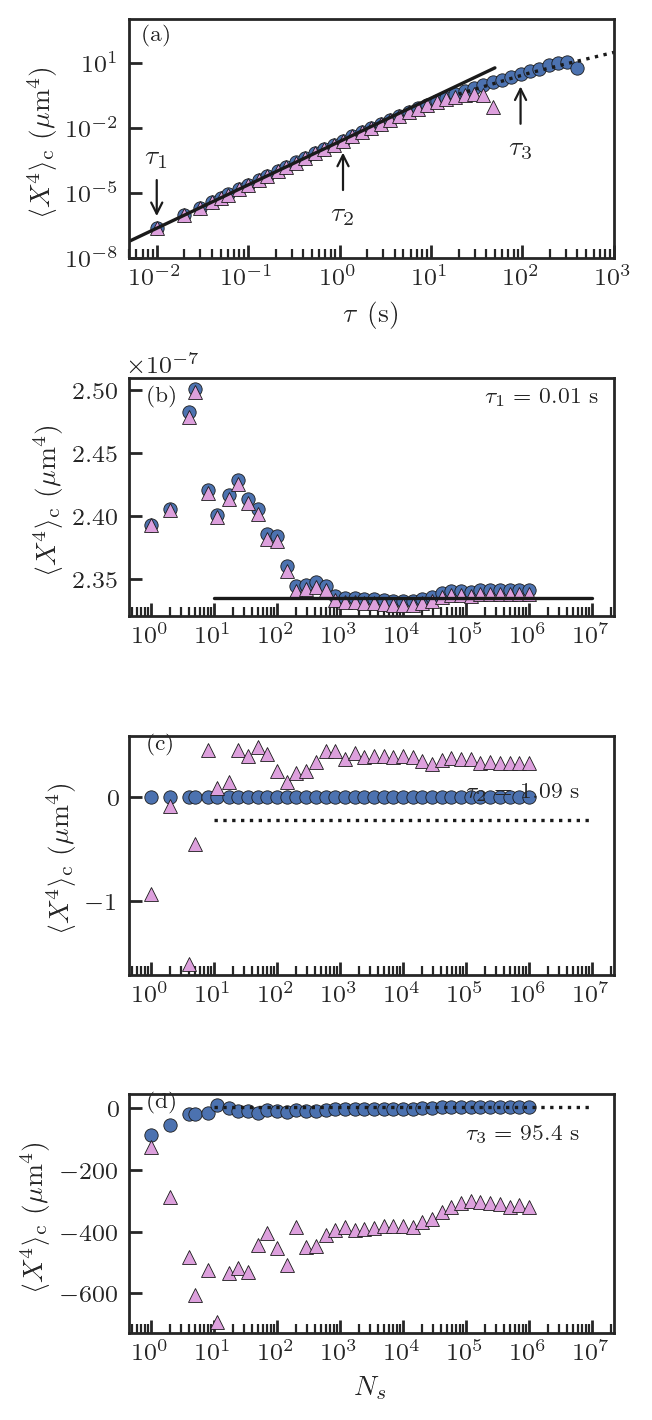

In [45]:
fig = plt.figure(figsize = (3.3, 12/1.68),  tight_layout=True)


ax1 = plt.subplot(411)
ax1.loglog(tau_x[:-4], np.array(C4_x[:-4])*1e24, "o", label="M1")
ax1.loglog(np.array(M2_c4["time (s)"]), np.array(M2_c4["C4 (m^4)"])*1e24, "^", color="plum", label="M2")
ax1.plot(t_short, A4_theo_x*t_short**2*1e24, "k-" )
ax1.plot(t_long, (24*D4_long_theo*t_long-24*C4_long_theo)*1e24, "k:" )
ax1.annotate(r"$\tau _1$", (tau_x[n_court], C4_x[n_court]*2*1e24), 
             xytext=(tau_x[n_court], C4_x[n_court]*1000*1e24), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
ax1.annotate(r"$\tau _2$", (tau_x[n_mid], C4_x[n_mid]/2*1e24), 
             xytext=(tau_x[n_mid], C4_x[n_mid]/5000*1e24), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
ax1.annotate(r"$\tau _3$", (tau_x[n_long], C4_x[n_long]/2*1e24),
             xytext=(tau_x[n_long], C4_x[n_long]/5000*1e24), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)

ax1.set(
    xlabel = r"$\tau$ (s)",
    ylabel = r"$\langle X^4 \rangle_\mathrm{c}$ ($\mu$m$^{4}$)",
)    
ax1.set_xlim(5e-3, 1e3)
ax1.set_ylim(1e-32*1e24, 1e-21*1e24)
ax1.text(7e-3, 1e-22*1e24, r"(a)", transform=ax1.transData)

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())



ax2 = plt.subplot(412)
ax2.semilogx(Nss, C4_x_Ns_1*1e24, "o", label=r"M1")
ax2.semilogx(Nss, C4_x_Ns_11*1e24, "^", color="plum", label=r"M2")
ax2.plot(np.linspace(10, 1e7, 100), np.ones(100)*Convergence_court*1e24, "k-", label=r"Theory")
ax2.text(2e5, 2.49e-7, r"$\tau_1 = $ "+ str(Ntime[n_court]*dt) + " s")

ax2.set(
    # xlabel = r"$N_s$",
    ylabel = r"$\langle X^4 \rangle_\mathrm{c}$ ($\mu$m$^{4}$)",
)
ax2.text(0.9, 2.49e-31*1e24, r"(b)", transform=ax2.transData)

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax2.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax2.xaxis.set_minor_locator(locmin)
ax2.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax3 = plt.subplot(413)
ax3.semilogx(Nss, C4_x_Ns_0*1e24, "o", label=r"M1")
ax3.semilogx(Nss, C4_x_Ns_00*1e24, "^", color="plum", label=r"M2")
ax3.plot(np.linspace(10, 1e7, 100), np.ones(100)*Convergence_mid*1e24, "k:", label=r"Theory")
ax3.text(1e5, 0, r"$\tau_2 = $ "+ str(Ntime[n_mid]*dt) + " s")
ax3.set(
    # xlabel = r"$N_s$",
    ylabel = r"$\langle X^4 \rangle_\mathrm{c}$ ($\mu$m$^{4}$)",
)
ax3.text(0.9, 4.5e-25*1e24, r"(c)", transform=ax3.transData)    

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax3.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax3.xaxis.set_minor_locator(locmin)
ax3.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


ax4 = plt.subplot(414)
ax4.semilogx(Nss, C4_x_Ns_2*1e24, "o", label=r"M1")
ax4.semilogx(Nss, C4_x_Ns_22*1e24, "^", color="plum", label=r"M2")
ax4.plot(np.linspace(10, 1e7, 100), np.ones(100)*Convergence_long*1e24, "k:", label=r"Theory")
ax4.text(1e5, -100, r"$\tau_3 = $ "+ str(Ntime[n_long]*dt) + " s", fontsize=8)
ax4.set(
    xlabel = r"$N_s$",
    ylabel = r"$\langle X^4 \rangle_\mathrm{c}$ ($\mu$m$^{4}$)",
)   
ax4.text(0.9, 1e-24*1e24, r"(d)", transform=ax4.transData)    
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax4.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax4.xaxis.set_minor_locator(locmin)
ax4.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


fig.tight_layout()

# plt.savefig("Figures/ConvergenceC4_court-long_Nsimu.pdf")

# REPONSE REFERY

In [46]:
Convergence_court,Convergence_mid,Convergence_long

(2.335706168867776e-31, -2.15200344e-25, 2.65733136e-24)

In [47]:
err_court1 = np.abs(Convergence_court-C4_x_Ns_1[-1])/Convergence_court * 100
err_court2 =  np.abs(Convergence_court-C4_x_Ns_11[-1])/Convergence_court * 100

err_mid1 = np.abs(Convergence_mid-C4_x_Ns_0[-1])/Convergence_mid * 100
err_mid2 = np.abs(Convergence_mid-C4_x_Ns_00[-1])/Convergence_mid * 100

err_long1 = np.abs(Convergence_long-C4_x_Ns_2[-1])/Convergence_long * 100
err_long2 = np.abs(Convergence_long-C4_x_Ns_22[-1])/Convergence_long * 100


In [48]:
(err_court1, err_court2), (err_mid1, err_mid2), (err_long1, err_long2) 

((0.2563170332924371, 0.11795900208388152),
 (-101.20569386284974, -254.10417745337946),
 (23.661779194338678, 12189.176595629435))

In [49]:
analytic = np.loadtxt('C4_Datas/THEORY_EIGENVALUES_FOR_C4.txt',dtype="float" )

analytic_time = analytic[:,0]
analytic_C4 = analytic[:,1]
analytic_kurtosis = ((analytic_C4 + 3*(2*mean_Dx*analytic_time)**2) / (2*mean_Dx*analytic_time)**2) - 3

In [50]:
# # SEMI-EXPERIENCE YACINE
# experience = loadmat("C4_Datas/Experience_time-C4-Kurtosis.mat", squeeze_me=True)
# experience = experience["Koexp"]

# experience_time = experience[:,0]
# experience_C4 = experience[:,1]*24
# experience_Kurtosis = experience[:,2]

In [171]:
## SEMI-EXPERIENCE NICO LE CHAUVAIN

experience = loadmat("C4_Datas/C4_kurtosis_semi_experimental_exp_20211019_from_20221003.mat")

experience_C4 = experience["C4"][0]
experience_errC4 = experience["err_C4"][0]
experience_Kurtosis = experience["kurtosis"][0]
experience_errKurtosis = experience["err_kurtosis"][0]
experience_time = experience["time"][0]


experience_dX_0p01 = experience["pdf_0"]["bins_center"][0][0][0]
experience_PDF_0p01 = experience["pdf_0"]["pdf"][0][0][0]
experience_PDFstd_0p01 = experience["pdf_0"]["pdf_err"][0][0][0]

experience_dX_1 = experience["pdf_2"]["bins_center"][0][0][0]
experience_PDF_1 = experience["pdf_2"]["pdf"][0][0][0]
experience_PDFstd_1 = experience["pdf_2"]["pdf_err"][0][0][0]
# experience


In [140]:


# experience = loadmat("C4_Datas/c4_kurtosis_semi_experimental.mat", squeeze_me=True)

# experience_time = experience["time"]
# experience_C4 = experience["C4"]
# experience_errC4 = experience["err_C4"]
# experience_Kurtosis = experience["kurtosis"]
# experience_errKurtosis = experience["err_kurtosis"]


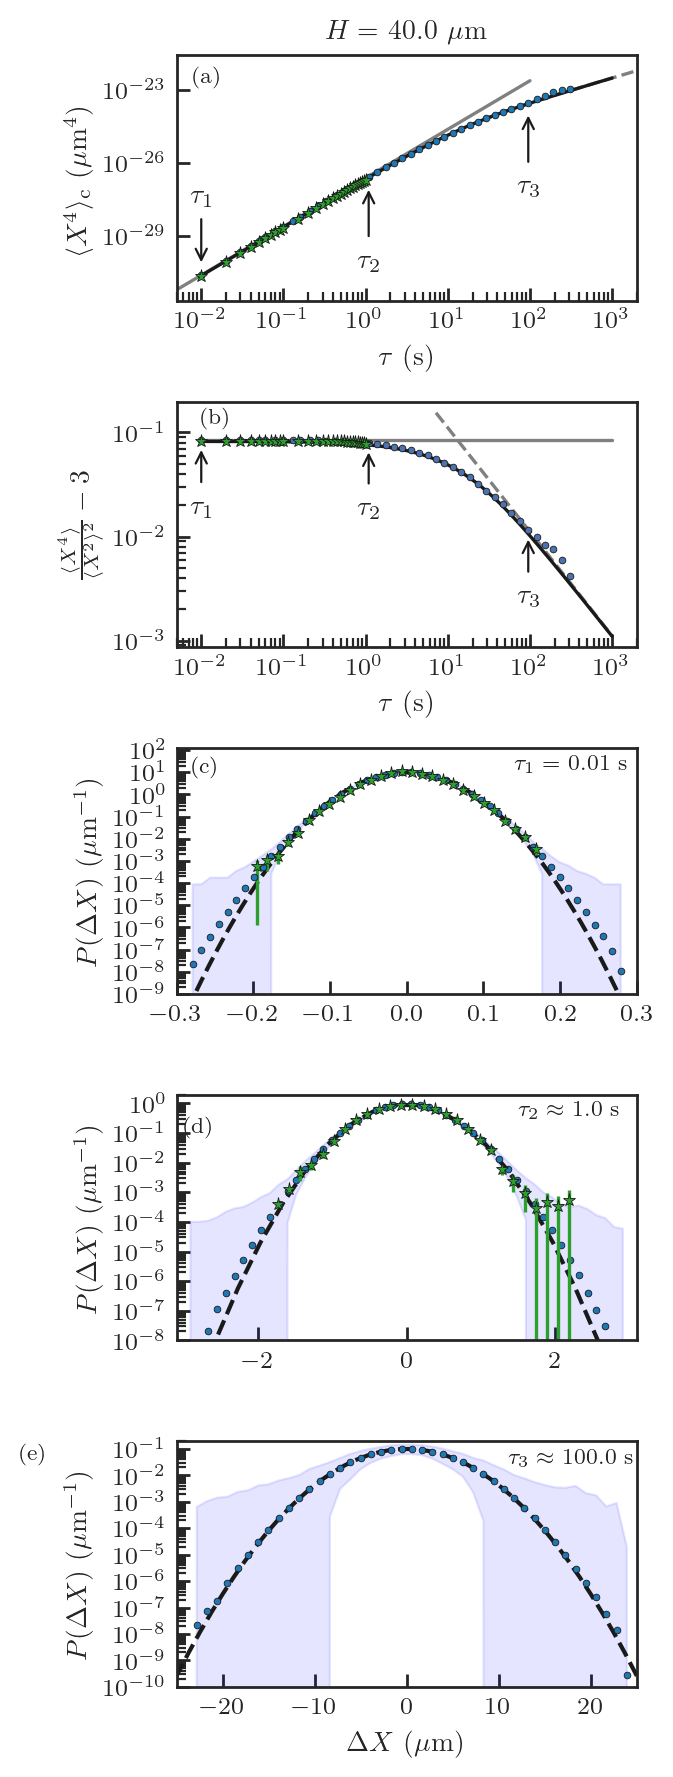

In [172]:
fig = plt.figure(figsize = (3.3, 15/1.68),  tight_layout=True)

# C4
axC4 = plt.subplot(511)
axC4.plot(np.linspace(5e-3, 100, 1000), A4_theo_x*np.linspace(5e-3, 100, 1000)**2, "-", color="grey" )
axC4.plot(np.linspace(30, 3000, 1000), (24*D4_long_theo*np.linspace(30, 3000, 1000)-24*C4_long_theo), "--", color="grey")
axC4.loglog(analytic_time, analytic_C4, "k-")
axC4.loglog(tau_x[:-5], C4_x[:-5], ".", color="tab:blue", label="M1")
axC4.errorbar(experience_time[:-3], experience_C4[:-3], yerr=experience_errC4[:-3], fmt='*', linestyle="",color="tab:green",)

axC4.annotate(r"$\tau _1$", (tau_x[n_court], C4_x[n_court]*2), 
             xytext=(tau_x[n_court], C4_x[n_court]*1000), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
axC4.annotate(r"$\tau _2$", (tau_x[n_mid], C4_x[n_mid]/2), 
             xytext=(tau_x[n_mid], C4_x[n_mid]/5000), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
axC4.annotate(r"$\tau _3$", (tau_x[n_long], C4_x[n_long]/2),
             xytext=(tau_x[n_long], C4_x[n_long]/5000), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
axC4.set(
    xlabel = r"$\tau$ (s)",
    ylabel = r"$\langle X^4 \rangle_\mathrm{c}$ ($\mu$m$^{4}$)",
)
axC4.set_xlim([5e-3, 2e3])
axC4.text(8e-3, 2e-23, r"(a)", transform=axC4.transData)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
axC4.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
axC4.xaxis.set_minor_locator(locmin)
axC4.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
plt.title(r"$H = $ "+str(H*1e6) + r" $\mu \mathrm{m}$")




# KURTOSIS
axKU = plt.subplot(512)
axKU.plot(tau_x, np.ones(len(tau_x))*A4_theo_x/(4*mean_Dx**2), "-", color="grey")
axKU.plot(tau_x[25:], 24*D4_long_theo/(4*mean_Dx**2) / tau_x[25:] , "--", color="grey")
axKU.loglog(analytic_time, analytic_kurtosis, "k-")
axKU.loglog(tau_x[:-5], C4_x_normalised[:-5], ".")
axKU.errorbar(experience_time[:-3], experience_Kurtosis[:-3], yerr=experience_errKurtosis[:-3], fmt='*', linestyle="",color="tab:green",)
axKU.annotate(r"$\tau _1$", (tau_x[n_court], C4_x_normalised[n_court]/1.1), 
             xytext=(tau_x[n_court], C4_x_normalised[n_court]/5), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
axKU.annotate(r"$\tau _2$", (tau_x[n_mid], C4_x_normalised[n_mid]/1.08), 
             xytext=(tau_x[n_mid], C4_x_normalised[n_mid]/4.8), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
axKU.annotate(r"$\tau _3$", (tau_x[n_long], C4_x_normalised[n_long]/1.1),
             xytext=(tau_x[n_long], C4_x_normalised[n_long]/5), ha="center",
            arrowprops=dict(arrowstyle = "->", lw = 0.8, color= "k"), fontsize=10)
axKU.set(
    xlabel = r"$\tau$ (s)",
    ylabel = r"$\frac{\langle X^4 \rangle }{ \langle X^2 \rangle^2} - 3$",
)
axKU.set_xlim([5e-3, 2e3])
axKU.text(1e-2, 1.2e-1, r"(b)", transform=axKU.transData)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
axKU.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
axKU.xaxis.set_minor_locator(locmin)
axKU.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())



# PDF1
ax1 = plt.subplot(513)
Mean1 = np.mean(data_1, axis=0)
Z1 = np.trapz(Mean1, dx_1*1e6)
Min = np.min(data_1, axis=0)
Max = np.max(data_1, axis=0)
Gauss1 = gauss(dxCOURT, 0, np.sqrt(2*mean_Dx*Ntime[n_court]*dt)) 
ax1.semilogy(dxCOURT*1e6, Gauss1/ np.trapz(Gauss1, dxCOURT*1e6) , "--", color="k", linewidth=1.5,)
ax1.errorbar(experience_dX_0p01*1e6, experience_PDF_0p01/ np.trapz(experience_PDF_0p01, experience_dX_0p01*1e6), yerr=experience_PDFstd_0p01/ np.trapz(experience_PDF_0p01, experience_dX_0p01*1e6), fmt='*', linestyle="",color="tab:green",)
ax1.semilogy(dx_1*1e6, Mean1/ Z1,".", color="tab:blue")
ax1.fill_between(dx_1*1e6, Min / Z1, Max / Z1, color='blue', alpha=0.1)

ax1.text(0.14, 14, r"$\tau_1 = $ "+ str(round(Ntime[n_court]*dt, 2)) + " s", fontsize=8)
ax1.set_xlim(-0.3, 0.3)
# ax1.set_ylim(1e-5, 2e1)
ax1.set(
    # xlabel = r"$\Delta x$ ($\mu$m)",
    ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
)
ax1.text(-0.28, 10, r"(c)", transform=ax1.transData)
ax1.set_ylim(1e-9, None)

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax1.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())




#PDF2
ax0 = plt.subplot(514)
Mean0 = np.mean(data_0, axis=0)
Z0 = np.trapz(Mean0, dx_0*1e6)
Min = np.min(data_0, axis=0)
Max = np.max(data_0, axis=0)
Gauss0 = gauss(dxMID, 0, np.sqrt(2*mean_Dx*tau_x[n_mid])) 

ax0.plot(dxMID*1e6, Gauss0 / np.trapz(Gauss0, dxMID*1e6), "--", color="k",linewidth=1.5,)
ax0.semilogy(dx_0*1e6, Mean0/ Z0,".", color="tab:blue")
norm=np.trapz(experience_PDF_1, experience_dX_1*1e6)
ax0.errorbar(experience_dX_1*1e6, experience_PDF_1/norm, yerr=experience_PDFstd_1/norm, fmt='*', linestyle="",color="tab:green",)
ax0.fill_between(dx_0*1e6, Min / Z0, Max / Z0, color='blue', alpha=0.1)
loadmat

ax0.set_xlim(-3.1, 3.1)
ax0.set_ylim(1e-8, 2e0)
ax0.text(1.5, 4e-1, r"$\tau_2 \approx $ "+ str(round(Ntime[n_mid]*dt, 0)) + " s", fontsize=8)
ax0.set(
    # xlabel = r"$\Delta x$ ($\mu$m)",
    ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
)
ax0.text(-3, 1e-1, r"(d)", transform=ax0.transData)   

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax0.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax0.yaxis.set_minor_locator(locmin)
ax0.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())



#PDF3
ax2 = plt.subplot(515)
Mean2 = np.mean(data_2, axis=0)
Min = np.min(data_2, axis=0)
Max = np.max(data_2, axis=0)
Z2 = np.trapz(Mean2, dx_2*1e6)
Gauss2 = gauss(dxLONG, 0, np.sqrt(2*mean_Dx*tau_x[n_long]))

ax2.semilogy(dxLONG*1e6, Gauss2 / np.trapz(Gauss2, dxLONG*1e6), "--", color="k",linewidth=1.5,)
ax2.plot(dx_2*1e6, Mean2 / Z2, ".", color="tab:blue")
ax2.fill_between(dx_2*1e6, Min / Z2, Max / Z2, color='blue', alpha=0.1)
1239
# ax2.plot(dXX, PDF_theory_x2/np.trapz(PDF_theory_x2,dXX), "-k")
ax2.set_xlim(-25, 25)
ax2.set_ylim(1e-10, 2e-1)
ax2.text(11, 3e-2, r"$\tau_3 \approx $ "+ str(round(Ntime[n_long]*dt,-1)) + " s", fontsize=8)
ax2.set(
    xlabel = r"$\Delta X$ ($\mu$m)",
    ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
)
ax2.text(-42, 4e-2, r"(e)", transform=ax2.transData)  

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax2.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax2.yaxis.set_minor_locator(locmin)
ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())



fig.tight_layout()

# plt.savefig("Figures/Simu_C4-Kurtosis-PDF_Large-Gap_H-40micron.pdf")